In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

sns.set(style='darkgrid', font_scale=2)
blue, green, red, purple = sns.color_palette('deep', n_colors=4)

/Users/noahsilbert/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Data analysis: linear models, generalized linear models, etc

There are a number of packages designed for model fitting and evaluation in Python. Two in particular come bundled with Anaconda: [`statsmodels`](http://statsmodels.sourceforge.net/stable/index.html) and `scikit-learn`. We'll work with parts of each, beginning with `statsmodels`. We will (probably) also work with [`pystan`](https://pystan.readthedocs.io/en/latest/index.html) later on, when we get to Bayesian data analysis.

First, note the slightly different import statement in the code block above. In order to import and use `statsmodels`, we need to import the api (application program interface). The standard abbreviation is `sm`. Note also that we've imported `statsmodels.formula.api` as `smf`.

We can illustrate some of the useful tools in `sm` with the consonant acoustics data we have looked at before. Because there are multiple repetitions of each consonant by each speaker, we will just take a subset of the data (in this case, the first repetition).

In [3]:
cons_all = pd.read_csv('consonant_acoustics_subset_labels.csv') # read in data file
cons_all.sort_values(by=['subject','consonant','slab','token'], inplace=True) # sort the data
cons_first = cons_all.groupby(['subject','consonant','slab']).first() # take just the first repetition
cons_first.head(n=10)

voice  place  manner  prosody  condur  vowdur  token  \
subject consonant slab                                                          
1       b         coda       1      0       0        1     108     214      1   
                  onset      1      0       0        0      15     184      1   
        d         coda       1      1       0        1      96     226      1   
                  onset      1      1       0        0      17     208      1   
        f         coda       0      0       1        1     220     168      1   
                  onset      0      0       1        0     126     209      1   
        p         coda       0      0       0        1     143     168      1   
                  onset      0      0       0        0      39     166      1   
        s         coda       0      1       1        1     215     193      1   
                  onset      0      1       1        0     159     166      1   

                         noipow  voipow       vlab      plab       mlab  
subject consonant slab                                                   
1       b         coda   142.09  117.84     voiced    labial       stop  
                  onset  138.55  119.30     voiced    labial       stop  
        d         coda   125.93  117.03     voiced  alveolar       stop  
                  onset  140.72  119.62     voiced  alveolar       stop  
        f         coda   142.80  111.24  voiceless    labial  fricative  
                  onset  152.67  118.22  voiceless    labial  fricative  
        p         coda   145.16  120.06  voiceless    labial       stop  
                  onset  140.55  120.55  voiceless    labial       stop  
        s         coda   152.83  113.49  voiceless  alveolar  fricative  
                  onset  162.08  109.67  voiceless  alveolar  fricative

In [4]:
cons_first.reset_index(level=['subject','consonant','slab'], inplace=True) # make index into columns
cons_first.head(n=10)

,subject,consonant,slab,voice,place,manner,prosody,condur,vowdur,token,noipow,voipow,vlab,plab,mlab
0,1,b,coda,1,0,0,1,108,214,1,142.09,117.84,voiced,labial,stop
1,1,b,onset,1,0,0,0,15,184,1,138.55,119.30,voiced,labial,stop
2,1,d,coda,1,1,0,1,96,226,1,125.93,117.03,voiced,alveolar,stop
3,1,d,onset,1,1,0,0,17,208,1,140.72,119.62,voiced,alveolar,stop
4,1,f,coda,0,0,1,1,220,168,1,142.80,111.24,voiceless,labial,fricative
5,1,f,onset,0,0,1,0,126,209,1,152.67,118.22,voiceless,labial,fricative
6,1,p,coda,0,0,0,1,143,168,1,145.16,120.06,voiceless,labial,stop
7,1,p,onset,0,0,0,0,39,166,1,140.55,120.55,voiceless,labial,stop
8,1,s,coda,0,1,1,1,215,193,1,152.83,113.49,voiceless,alveolar,fricative
9,1,s,onset,0,1,1,0,159,166,1,162.08,109.67,voiceless,alveolar,fricative


In [5]:
cols = ['voice','vlab','place','plab','manner','mlab','prosody','slab','noipow','voipow','condur','vowdur','token']
cons = cons_first[cols].copy() # make a copy, with just the subset of columns in cols
cons.head(n=10)

,voice,vlab,place,plab,manner,mlab,prosody,slab,noipow,voipow,condur,vowdur,token
0,1,voiced,0,labial,0,stop,1,coda,142.09,117.84,108,214,1
1,1,voiced,0,labial,0,stop,0,onset,138.55,119.30,15,184,1
2,1,voiced,1,alveolar,0,stop,1,coda,125.93,117.03,96,226,1
3,1,voiced,1,alveolar,0,stop,0,onset,140.72,119.62,17,208,1
4,0,voiceless,0,labial,1,fricative,1,coda,142.80,111.24,220,168,1
5,0,voiceless,0,labial,1,fricative,0,onset,152.67,118.22,126,209,1
6,0,voiceless,0,labial,0,stop,1,coda,145.16,120.06,143,168,1
7,0,voiceless,0,labial,0,stop,0,onset,140.55,120.55,39,166,1
8,0,voiceless,1,alveolar,1,fricative,1,coda,152.83,113.49,215,193,1
9,0,voiceless,1,alveolar,1,fricative,0,onset,162.08,109.67,159,166,1


The `sm` module makes it easy to specify and fit linear regression models. You can use `R`-style syntax with a pandas data frame or with your data in numpy arrays. Here's an example using `R`-style syntax and the data frame defined above.

We will specify and fit a simple linear regression model to analyze how well the duration of consonants predicts their RMS energy.

We'll visualize the data before fitting a model:

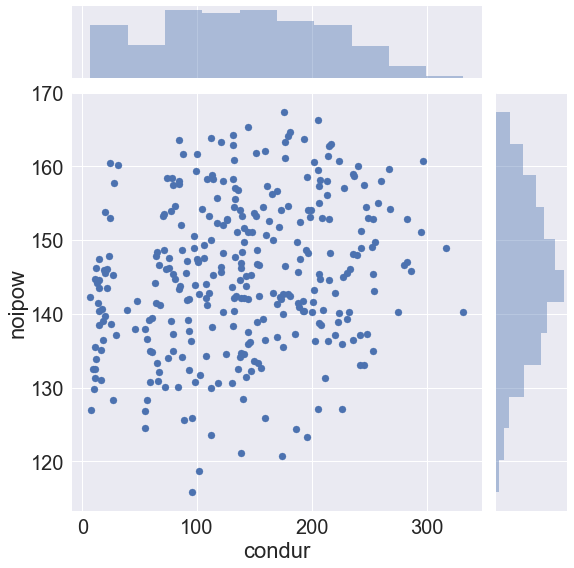

In [6]:
sns.jointplot(cons['condur'], cons['noipow'], size=8, stat_func=None);

In order to fit a standard linear regression model, we can use the `OLS` (ordinary least squares) method inside the `sm` module to create a model object, and then we can call the `fit` method of that model object. The `OLS` method requires arrays for the dependent variable (`endog`, for 'endogenous') and the independent variable(s) (`exog`, for 'exogenous').

The term 'ordinary least squares' refers to the fact that the model is fit (i.e., parameter values are found) such that the squared deviations of the observed data from the expected value is minimized.

Note that you have to include a column of ones if you want the model to have an intercept.

The model we'll fit is:

\begin{equation}
\hat{y}_i = \beta_0 + \beta_1 x_{i}
\end{equation}

In [9]:
y = cons['noipow'].as_matrix() # noipow = dependent/endogenous variable
x0 = np.ones(y.shape[0]) # for just estimating an intercept
x = np.stack((np.ones(y.shape[0]),cons['condur']),axis=1) # ones for intercept, condur = ind/exog variable
x[:5,:]

array([[   1.,  108.],
       [   1.,   15.],
       [   1.,   96.],
       [   1.,   17.],
       [   1.,  220.]])

Simple, intercept-only model (i.e., calculating the mean and variance of y in an unnecessarily complicated way):

In [10]:
mod_0 = sm.OLS(endog=y, exog=x0) # intercept-only model
fit_0 = mod_0.fit()
print(fit_0.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                      -inf
Date:                Fri, 23 Mar 2018   Prob (F-statistic):                nan
Time:                        10:50:29   Log-Likelihood:                -1198.2
No. Observations:                 320   AIC:                             2398.
Df Residuals:                     319   BIC:                             2402.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        145.1809      0.573    253.458      0.0

/Users/noahsilbert/anaconda/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1396: RuntimeWarning: divide by zero encountered in double_scalars
  return self.ess/self.df_model


Adding in consonant duration as a predictor to see how much information it gives us about acoustic energy above and beyond just calculating the mean (and variance) of y:

In [8]:
mod_a = sm.OLS(endog=y, exog=x) # OLS model object
fit_a = mod_a.fit()
print(fit_a.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     16.55
Date:                Fri, 23 Mar 2018   Prob (F-statistic):           5.97e-05
Time:                        10:46:40   Log-Likelihood:                -1190.1
No. Observations:                 320   AIC:                             2384.
Df Residuals:                     318   BIC:                             2392.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        140.8704      1.198    117.585      0.0

Or, somewhat more conveniently, we can use the `ols` method inside `smf`. Using this with formula and data specified creates a model object, which again requires us to call the `fit` method:

In [20]:
fit_b = smf.ols('noipow ~ condur', data=cons).fit()
print(fit_b.summary())

                            OLS Regression Results                            
Dep. Variable:                 noipow   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     16.55
Date:                Fri, 23 Mar 2018   Prob (F-statistic):           5.97e-05
Time:                        11:04:55   Log-Likelihood:                -1190.1
No. Observations:                 320   AIC:                             2384.
Df Residuals:                     318   BIC:                             2392.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    140.8704      1.198    117.585      0.0

We can use the seaborn function `lmplot` to plot the data and the model's fitted values along with a bootstrap confidence interval around the fitted line:

In [13]:
y_mean = fit_0.params

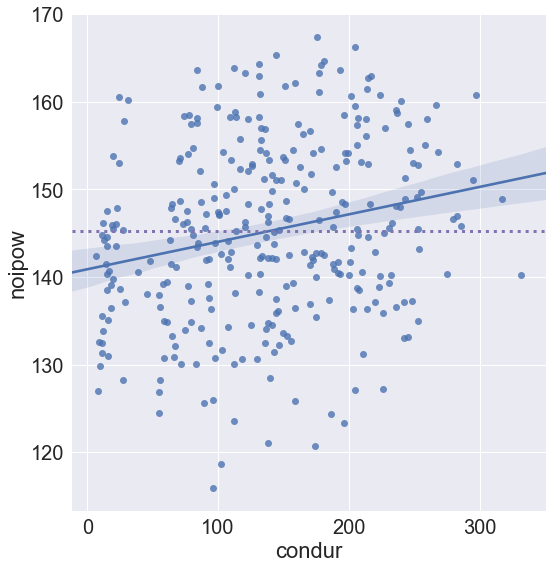

In [18]:
sns.lmplot(x='condur', y='noipow', data=cons, size=8)
ax = plt.gca()
ax.plot(ax.get_xlim(),y_mean*np.ones(2),':',color=purple, lw=3);

We could also plot the 'lowess' (locally weighted) regression line, instead:

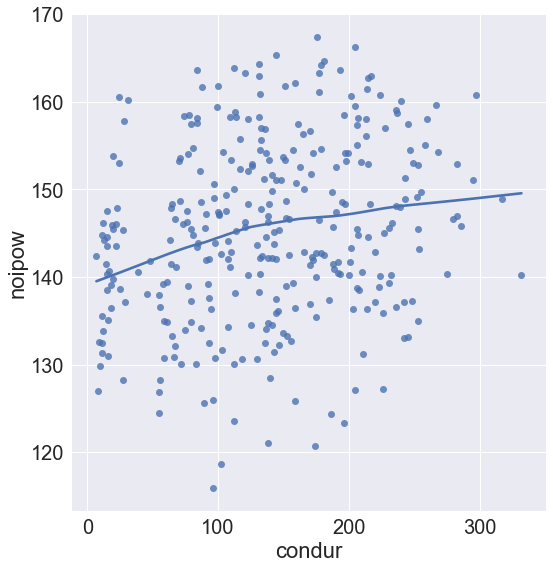

In [10]:
sns.lmplot(x='condur',y='noipow', data=cons, size=8, lowess=True);

The fitted model also allows us to generate predicted mean values and standard errors around these predicted mean values for values of the independent variable of interest:

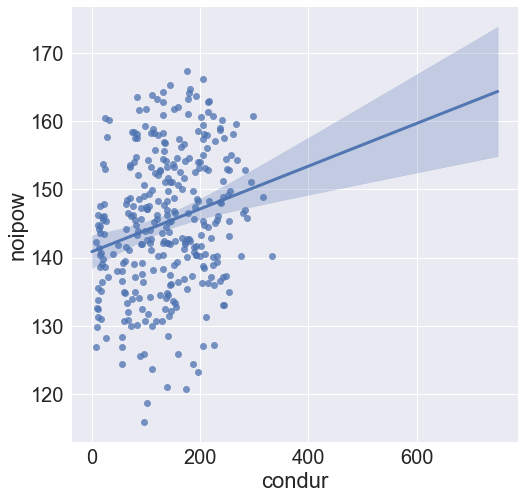

In [24]:
# create data frame with values of 'condur' at which we want predictions
x_new_d = pd.DataFrame({'condur':np.arange(0,751,50)})

# make array for plotting
x_new = x_new_d['condur'].as_matrix()

# generate predictions of noise power at new 'condur' values
y_pred = fit_b.get_prediction(x_new_d)

fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.set_xlabel('condur'); ax.set_ylabel('noipow');
ax.plot(cons['condur'],cons['noipow'],'o',color=list(blue) + [.75])

y_pred_mean = y_pred.predicted_mean # predicted mean
y_pred_se = y_pred.se_mean # prediected standard error
y1 = y_pred_mean-2*y_pred_se; y2 = y_pred_mean+2*y_pred_se # prediction bounds

ax.fill_between(x=x_new,y1=y1,y2=y2,color=list(blue) + [.25])
ax.plot(x_new,y_pred_mean,'-',lw=3,color=list(blue) + [.95]);

### Multiple regression

Of course, we can also fit more complicated models. Here is a model predicting consonant duration as a function of vowel duration, syllable position (`slab`: onset vs coda), and the interaction between these two factors.

Note that, because syllable position is a dichotomous variable, the presence of this variable in the model allows the onset and coda data to have different intercepts, and the interaction term allows for vowel duration to have a different slope for onset and coda positions.

If syllable position is indicated by $S$ and encoded with onset = 1 and coda = 0, with estimated consonant duration indicated by $\hat{C}$ and vowel duration by $V$, then the model is:

\begin{equation}
\hat{C}_i = \beta_0 + \beta_1 V_i + \beta_2 S_i  + \beta_3 V_i \times S_i
\end{equation}

For coda consonants, $S_i = 0$, so this reduces to:

\begin{equation}
\hat{C}_i = \beta_0 + \beta_1 V_i
\end{equation}

Whereas for onset consonants, $S_i = 1$, so the model is:

\begin{align}
\hat{C}_i &= \beta_0 + \beta_1 V_i + \beta_2 S_i  + \beta_3 V_i \times S_i\\
&= \beta_0 + \beta_1 V_i + \beta_2  + \beta_3 V_i\\
&= \left(\beta_0 + \beta_2 \right) + \left(\beta_1 + \beta_3\right) V_i
\end{align}

Here's the model, using a formula and the `smf` module:

In [28]:
fit_c = smf.ols('condur ~ vowdur + slab + vowdur:slab', data=cons).fit()
print(fit_c.summary())

                            OLS Regression Results                            
Dep. Variable:                 condur   R-squared:                       0.442
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                     83.47
Date:                Fri, 23 Mar 2018   Prob (F-statistic):           8.55e-40
Time:                        11:12:11   Log-Likelihood:                -1732.2
No. Observations:                 320   AIC:                             3472.
Df Residuals:                     316   BIC:                             3487.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              225.9845 

We can parameterize the model in terms of the overall intercept vs deviations from this for coda and onset consonants.

If we code coda as -0.5 and onset as +0.5, for coda consonants the model will be:

\begin{align}
\hat{C}_i &= \beta_0 + \beta_1 V_i - 0.5\beta_2 - 0.5\beta_3 V_i\\
\hat{C}_i &= (\beta_0 - 0.5\beta_2) + (\beta_1 - 0.5\beta_3) V_i
\end{align}

and for onset consonants it will be:

\begin{align}
\hat{C}_i &= \beta_0 + \beta_1 V_i + 0.5\beta_2 + 0.5\beta_3 V_i\\
\hat{C}_i &= (\beta_0 + 0.5\beta_2) + (\beta_1 + 0.5\beta_3) V_i
\end{align}

In [30]:
cons['pros_ec'] = -1*cons['prosody']+.5
cons.head()

,voice,vlab,place,plab,manner,mlab,prosody,slab,noipow,voipow,condur,vowdur,token,pros_ec
0,1,voiced,0,labial,0,stop,1,coda,142.09,117.84,108,214,1,-0.5
1,1,voiced,0,labial,0,stop,0,onset,138.55,119.30,15,184,1,0.5
2,1,voiced,1,alveolar,0,stop,1,coda,125.93,117.03,96,226,1,-0.5
3,1,voiced,1,alveolar,0,stop,0,onset,140.72,119.62,17,208,1,0.5
4,0,voiceless,0,labial,1,fricative,1,coda,142.80,111.24,220,168,1,-0.5


In [31]:
fit_c2 = smf.ols('condur ~ vowdur + pros_ec + vowdur:pros_ec', data=cons).fit()
print(fit_c2.summary())

                            OLS Regression Results                            
Dep. Variable:                 condur   R-squared:                       0.442
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                     83.47
Date:                Fri, 23 Mar 2018   Prob (F-statistic):           8.55e-40
Time:                        11:20:04   Log-Likelihood:                -1732.2
No. Observations:                 320   AIC:                             3472.
Df Residuals:                     316   BIC:                             3487.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        148.6635     14.137     10.

We can visualize the data and model prediction for onset and coda separately by specifying the `col` and `hue` arguments in `lmplot`:

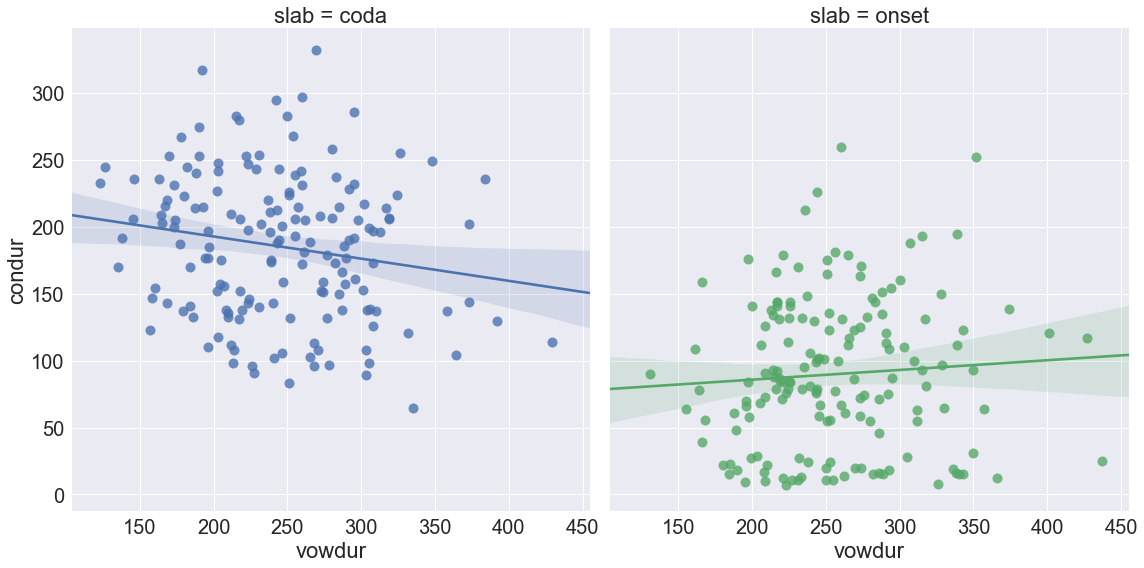

In [32]:
sns.lmplot(x='vowdur', y='condur', data=cons, col='slab',
           hue='slab', size=8, scatter_kws={'s':100});

### Multilevel linear regression

The statsmodels package also has the ability to fit 'mixed effects' linear models. I prefer to refer to this kind of model as a multilevel model. The basic idea is that if you have multiple observations within some grouping unit (e.g., multiple acoustic measurements for a given talker), you can simultaneously (a) fit a model to each unit's data and (b) fit a model governing variation across these units.

A more concrete example will probably help clarify. In this case, we'll be predicting consonant duration as a function of each consonant's voicing (voiceless = 0, voiced = 1) and manner of articulation (stop = 0, fricative = 1).

Recall that we just took the first observation of the consonant acoustic data above. The full data set has 10 repetitions of each of 8 consonants from each speaker (in each syllable position). In theory, we could fit a model to each set of repetitions from each speaker. If we did this, we would get beta coefficients for each subject. A multilevel model allows us to do this, while simultaneously modeling the variation in the beta coefficients across speakers.

Here's what the full data set looks like:

In [33]:
cons_all.head()

,consonant,voice,place,manner,prosody,condur,vowdur,subject,token,noipow,voipow,vlab,plab,mlab,slab
2105,b,1,0,0,1,108,214,1,1,142.09,117.84,voiced,labial,stop,coda
3164,b,1,0,0,1,102,229,1,2,135.18,118.60,voiced,labial,stop,coda
2521,b,1,0,0,1,104,222,1,3,141.30,115.59,voiced,labial,stop,coda
1864,b,1,0,0,1,150,248,1,4,142.81,122.65,voiced,labial,stop,coda
2580,b,1,0,0,1,146,266,1,5,137.66,117.91,voiced,labial,stop,coda


We will fit a multilevel model to the coda data. In order to fit this model, we need a formula for the 'fixed effect' model (i.e., the group-level model) and a formula for the 'random effects' (i.e., the individual-level model). Note that the latter only refers to the independent variables, with a `1` indicating the intercept (which is included in the group-level model by default). Note, too, that we specify that `subject` is the grouping variable.

Note, too, that `voice` is coded 0 for voiceless and 1 for voiced consonants, and `manner` is coded 0 for stops and 1 for fricatives. This means that the overall group-level model is:

\begin{equation}
\hat{C}_i = \beta_0 + \beta_1 voice + \beta_2 manner
\end{equation}

So, for voiceless stops, this reduces to:

\begin{equation}
\hat{C}_i = \beta_0
\end{equation}

whereas for voiced stops, it is:

\begin{equation}
\hat{C}_i = \beta_0 + \beta_1
\end{equation}

and for voiceless fricatives, it is:

\begin{equation}
\hat{C}_i = \beta_0 + \beta_2
\end{equation}

and, finally, for voiced fricatives, it is:

\begin{equation}
\hat{C}_i = \beta_0 + \beta_1 + \beta_2
\end{equation}

In [34]:
cons_coda = cons_all.loc[cons_all['slab']=='coda',:].copy() # get just coda data

# specify "random effects" formula
#  this is the model fit to each subject's data
re_formula = '1 + voice + manner'

# specify "fixed effects" formula
#  this is the model governing the subject-level models
fe_formula = 'condur ~ voice + manner'

# create and fit model
fit_e = smf.mixedlm(formula=fe_formula, re_formula=re_formula,
                    groups=cons_coda['subject'], data=cons_coda).fit()
print(fit_e.summary())

                 Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      condur    
No. Observations:       1600         Method:                  REML      
No. Groups:             20           Scale:                   1387.9664 
Min. group size:        80           Likelihood:              -8116.2435
Max. group size:        80           Converged:               Yes       
Mean group size:        80.0                                            
------------------------------------------------------------------------
                          Coef.   Std.Err.    z    P>|z|  [0.025  0.975]
------------------------------------------------------------------------
Intercept                 190.318    7.441  25.577 0.000 175.733 204.902
voice                     -52.723    4.351 -12.116 0.000 -61.251 -44.194
manner                     36.257    5.229   6.934 0.000  26.008  46.507
Intercept RE             1055.335    9.699                           

We can extract the estimates of the 'random effects', or the individual speakers' beta coefficients:

In [35]:
re_df = pd.DataFrame(fit_e.random_effects).T
re_df.shape # n talkers, n model parameters

(20, 3)

In [36]:
re_df.head()

,Intercept,voice,manner
1,-30.803304,3.624868,25.643651
2,18.659346,-11.154684,22.345822
3,2.351439,16.664398,31.169308
4,-35.370452,2.400945,30.389889
5,-26.445095,10.216490,-2.533453


We can then plot the distributions of these values to visualize how the different speakers vary with respect to how voicing and manner influence consonant duration:

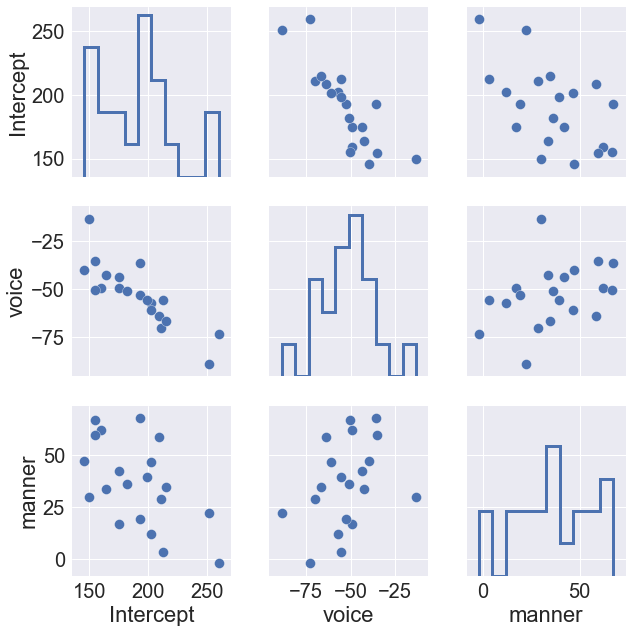

In [37]:
b0, b1, b2 = fit_e.params.loc[['Intercept','voice','manner']]
sns.pairplot(re_df + np.stack([b0,b1,b2]), size=3, plot_kws={'s':100},
             diag_kws={'histtype':'step', 'lw':3}, diag_kind='hist');

Finally, we can visualize the data using violin plots organized by speaker (panel), voicing (x-axis), and manner (color):

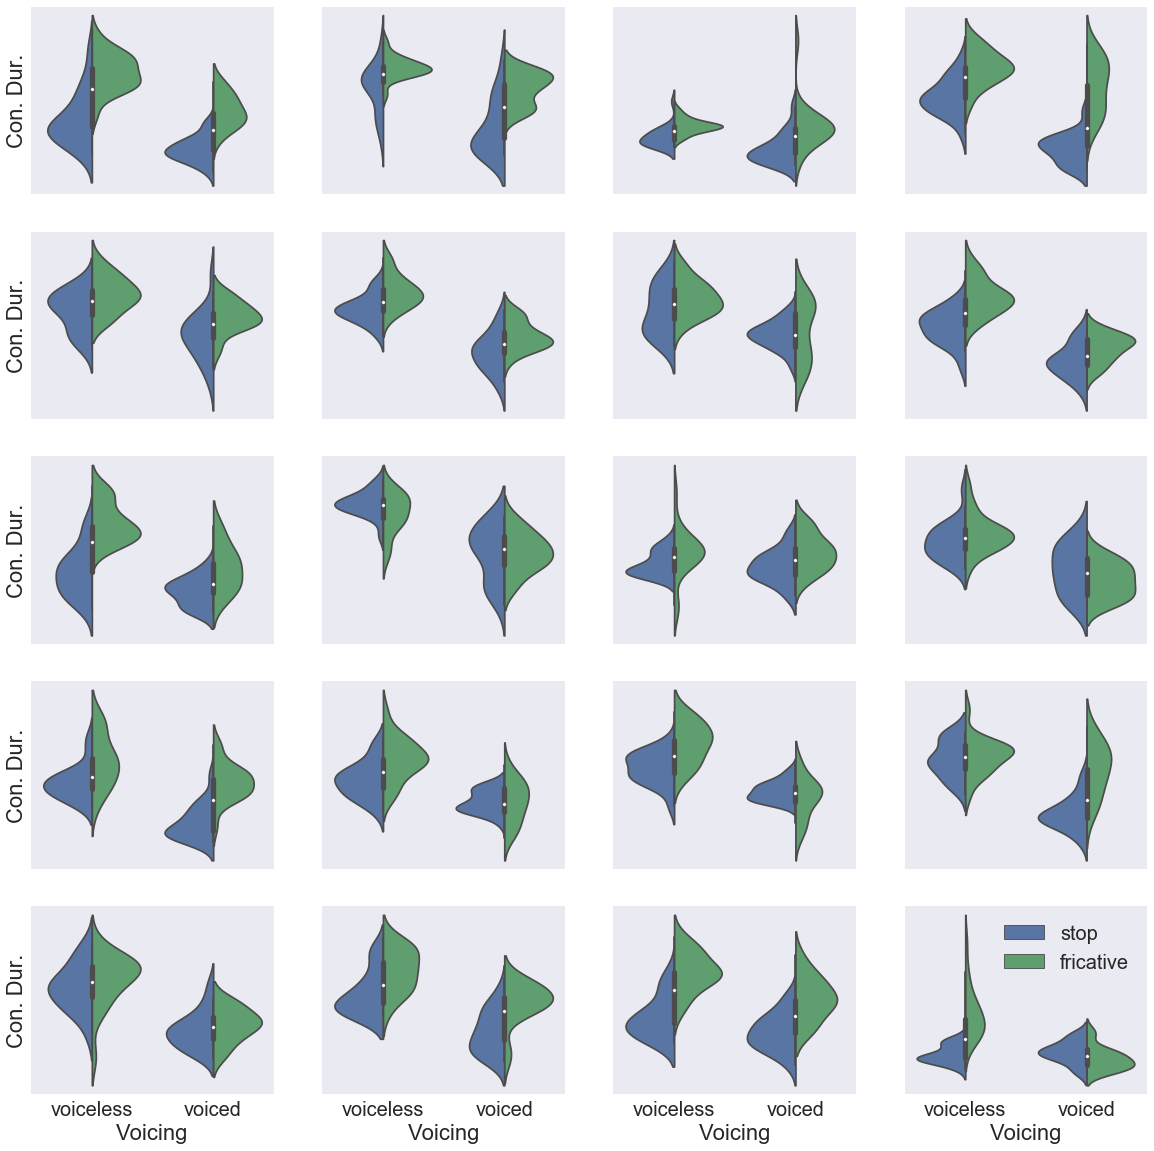

In [38]:
fig = plt.figure(figsize=(20,20))
for i in range(5):
    for j in range(4):
        idx = j + 4*i + 1
        ax = plt.subplot(5,4,idx)
        rows = np.in1d(cons_coda['subject'],idx)
        df_s = cons_coda.loc[rows,['condur','vlab','mlab']]
        sns.violinplot(y='condur', x='vlab', data=df_s, hue='mlab', ax=ax, split=True, order=['voiceless','voiced'])
        ax.set_yticks([])
        if idx not in [1,5,9,13,17]:
            ax.set_ylabel('')
        else:
            ax.set_ylabel('Con. Dur.')
        if idx not in [17,18,19,20]:
            ax.set_xlabel('')
            ax.set_xticklabels(['',''])
        else:
            ax.set_xlabel('Voicing')
        if idx < 20:
            ax.legend_.remove()
        else:
            ax.legend_.set_title('')
            
#fig.savefig('condur_by_svm.png',bbox_inches='tight')

The statsmodels package also allows us to get standard ANOVA results from an OLS model fit:

In [20]:
cons_onset = cons.loc[cons['slab']=='onset',:] # pull out onset data
# fit model with main effects and interactions for voicing, place, and manner
# 'condur ~ voice*place*manner' is same as 
#   'condur ~ voice + place + manner
#              + voice:place + voice:manner + place:manner
#              + voice:place:manner
condur_vpm_fit = smf.ols('condur ~ voice*place*manner', data=cons_onset).fit()
condur_vpm_ANOVA = sm.stats.anova_lm(condur_vpm_fit)
print(np.round(condur_vpm_ANOVA,2))

                       df     sum_sq    mean_sq       F  PR(>F)
voice                 1.0  125160.16  125160.16  118.58    0.00
place                 1.0    7062.31    7062.31    6.69    0.01
voice:place           1.0      31.51      31.51    0.03    0.86
manner                1.0  196070.01  196070.01  185.77    0.00
voice:manner          1.0     500.56     500.56    0.47    0.49
place:manner          1.0    4070.31    4070.31    3.86    0.05
voice:place:manner    1.0     218.56     218.56    0.21    0.65
Residual            152.0  160429.35    1055.46     NaN     NaN


/Users/noahsilbert/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/noahsilbert/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/noahsilbert/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Statsmodels also has functions for estimating group-level effects using a [generalized estimating equation](https://en.wikipedia.org/wiki/Generalized_estimating_equation). GEEs provide a robust way to test group-level effects with clustered (i.e., multilevel structured) data even when the covariance structure of the data (conditional on the model) is misspecified. We didn't go into detail about the covariance structure with the 'mixed effect' model above, but these models can produce questionable results when it is misspecified.

Fitting a GEE model and viewing the results is very similar to fitting and viewing a mixed effect model:

In [40]:
form = 'condur ~ voice + manner'
fit_f = smf.gee(form, groups=cons_coda['subject'], data=cons_coda).fit()
print(fit_f.summary())

                               GEE Regression Results                              
Dep. Variable:                      condur   No. Observations:                 1600
Model:                                 GEE   No. clusters:                       20
Method:                        Generalized   Min. cluster size:                  80
                      Estimating Equations   Max. cluster size:                  80
Family:                           Gaussian   Mean cluster size:                80.0
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Fri, 23 Mar 2018   Scale:                        2018.439
Covariance type:                    robust   Time:                         11:55:26
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    190.3175      7.254     26.235      0.000     176.099     204.536
voice  

### Generalized linear models

We can also fit generalized linear models by using the `glm` method rather than the `ols` method, in which case we have to specify exactly which kind of glm we're fitting.

In this case, we will fit a logistic regression model to predict voicing (voiced = 1, voiceless = 0) as a function of vowel duration, syllable position, and the interaction between vowel duration and syllable position. Note that, using the formula syntax, `vowdur*prosody` is equivalent to `vowdur + prosody + vowdur:prosody`.

Generalized linear models allow us to fit models to dependent variables that are not normally distributed around the expected value (e.g., the fitted value in the OLS models we fit above). The key additional component of a GLM is the link function, which transforms the linear combination of variables to produce an appropriate expected value for the type of dependent variable in question.

For logistic regression, the dependent variable for each row of the data should be either a [Bernoulli random variable](https://en.wikipedia.org/wiki/Bernoulli_distribution) (e.g., a variable indicating if a single coin flip is heads = 1 or tails = 0) or a [Binomial random variable](https://en.wikipedia.org/wiki/Binomial_distribution), which is a sum of independent Bernoulli random variables (e.g., the number of heads = k in the total number of coin flips = N).

For Bernoulli random variable $y$ with probablity $\theta$ of a 'heads', we write:

\begin{equation}
\Pr(y) = \theta^y (1-\theta)^{1-y}
\end{equation}

If $y = 1$, this reduces to:

\begin{equation}
\Pr(y) = \theta
\end{equation}

And if $y = 0$, this reduces to:

\begin{equation}
\Pr(y) = (1-\theta)
\end{equation}


The link function for logistic regression with dependent variable $y_i$ takes a linear combination of independent variables $X_i$ and maps it onto the interval (0,1) (i.e., it ensures that it is a reasonable value for a probability):

\begin{equation}
\Pr(y_i = 1) = \frac{1}{1+\exp\left(-\left(\beta_0 + \beta_1 x_{i1} + \cdots + \beta_p x_{ip} \right)\right)}
\end{equation}

Since we know how to make arrays of values and plots to illustrate functions of those values, let's do that with the logistic link function:

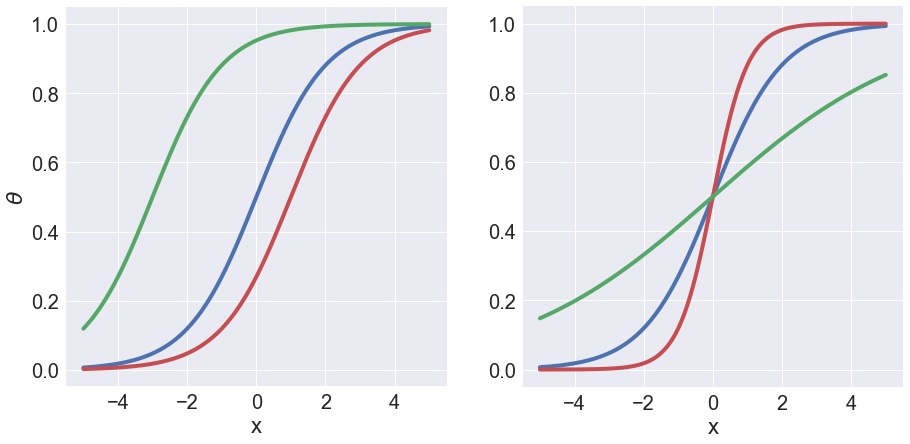

In [41]:
def logistic(x):
    return 1/(1+np.exp(-x))

x = np.linspace(-5,5,500)
y1 = logistic(0+1*x); y2 = logistic(-1+1*x); y3 = logistic(3+1*x)
y4 = logistic(0+2*x); y5 = logistic(0+.35*x)

fig, axes = plt.subplots(1,2,figsize=(15,15))
ax1, ax2 = axes; ax1.set_aspect(10); ax2.set_aspect(10)
ax1.plot(x,y1,color=blue,lw=4); ax1.plot(x,y2,color=red,lw=4); ax1.plot(x,y3,color=green,lw=4)
ax2.plot(x,y1,color=blue,lw=4); ax2.plot(x,y4,color=red,lw=4); ax2.plot(x,y5,color=green,lw=4)
ax1.set_ylabel(r'$\theta$'); ax1.set_xlabel('x'); ax2.set_xlabel('x');

We can use the `glm` method to create and fit a logistic regression model as follows:

In [44]:
cons.head()

,voice,vlab,place,plab,manner,mlab,prosody,slab,noipow,voipow,condur,vowdur,token,pros_ec
0,1,voiced,0,labial,0,stop,1,coda,142.09,117.84,108,214,1,-0.5
1,1,voiced,0,labial,0,stop,0,onset,138.55,119.30,15,184,1,0.5
2,1,voiced,1,alveolar,0,stop,1,coda,125.93,117.03,96,226,1,-0.5
3,1,voiced,1,alveolar,0,stop,0,onset,140.72,119.62,17,208,1,0.5
4,0,voiceless,0,labial,1,fricative,1,coda,142.80,111.24,220,168,1,-0.5


In [42]:
fit_d = smf.glm('voice ~ vowdur*prosody', data=cons, family=sm.families.Binomial()).fit()
print(fit_d.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  voice   No. Observations:                  320
Model:                            GLM   Df Residuals:                      316
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -190.39
Date:                Fri, 23 Mar 2018   Deviance:                       380.78
Time:                        12:02:56   Pearson chi2:                     343.
No. Iterations:                     5                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -2.0607      0.826     -2.494      0.013      -3.680      -0.442
vowdur             0.0081      0.003    

The coefficients of a logistic regression model are log odds-ratios. The odds of a dichotomous event are ratio of the probability of the event occurring and the probability of it not occurring:

\begin{equation}
odds = \frac{p}{1-p}
\end{equation}

The odds *ratio* is a ratio of odds (for p at, e.g., levels 1 and 2):

\begin{equation}
OR = \frac{\frac{p_1}{1-p_1}}{\frac{p_2}{1-p_2}}
\end{equation}

[Here](https://noahmotion.github.io/odds_ratios.html) is a notebook all about why odds ratios are uninterpretable and bad. It also briefly discusses a more intuitive way to interpret logistic regression coefficients.

Seaborn can plot data and fitted values for logistic regression, too:

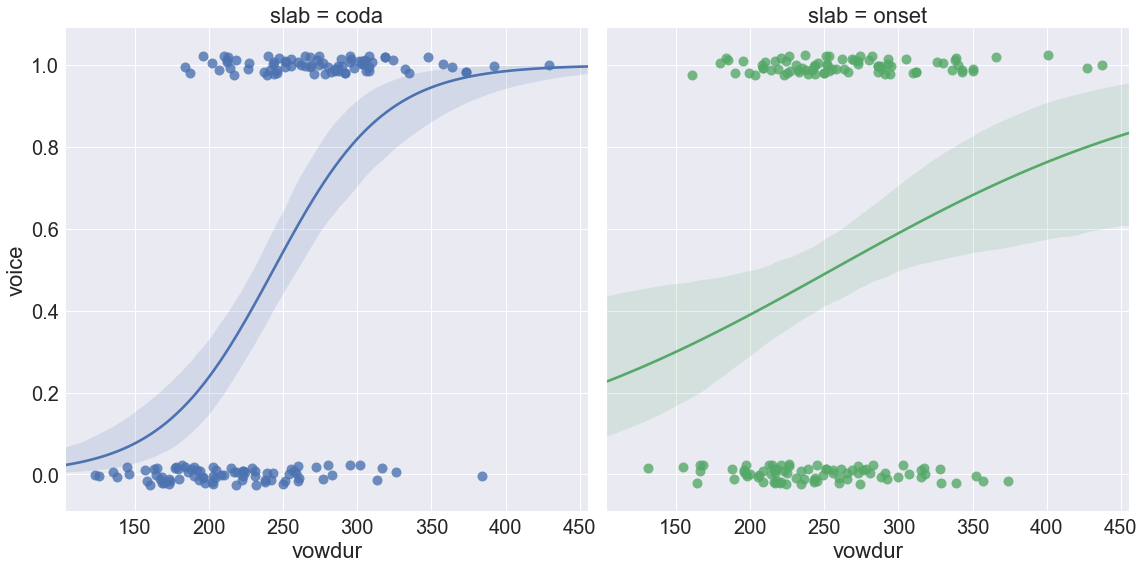

In [46]:
sns.lmplot(x='vowdur', y='voice', data=cons, hue='slab', col='slab',
           logistic=True, size=8, y_jitter=.025, scatter_kws={'s':100});

As with the linear model, we can generate predicted means (probabilities) for unobserved independent variable values:

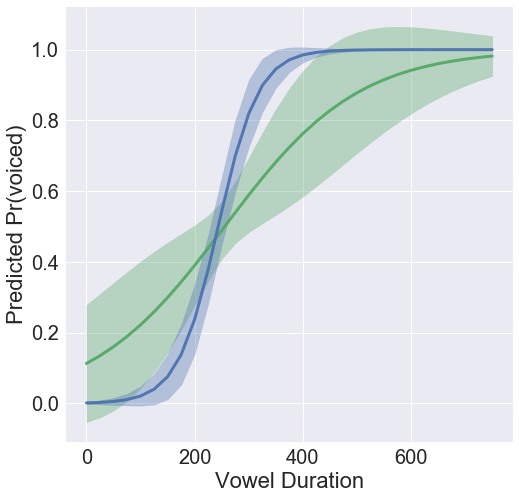

In [47]:
vowdur_new = np.concatenate((np.arange(0,751,25),np.arange(0,751,25)))
n_new = len(vowdur_new)
slab_new = np.concatenate((np.zeros(int(n_new/2),dtype=int),np.ones(int(n_new/2),dtype=int)))
x_new = pd.DataFrame({'vowdur':vowdur_new,'prosody':slab_new,'vowdur:prosody':vowdur_new*slab_new})
y_new = fit_d.get_prediction(x_new)
y_pred_mean = y_new.predicted_mean
y_pred_se = y_new.se_mean
fig, ax = plt.subplots(1,1,figsize=(8,8))
clrs = [list(green), list(blue)]
for i in range(2):
    idx = np.in1d(x_new['prosody'],i)
    y1 = y_pred_mean[idx]-2*y_pred_se[idx]
    y2 = y_pred_mean[idx]+2*y_pred_se[idx]
    ax.fill_between(x=x_new.loc[idx,'vowdur'],y1=y1,y2=y2,color=clrs[i] + [.35])
    ax.plot(x_new.loc[idx,'vowdur'],y_pred_mean[idx],'-',lw=3,color=clrs[i] + [.95])
ax.set_ylabel('Predicted Pr(voiced)')
ax.set_xlabel('Vowel Duration');

We can also transform variables in the formula using, e.g., numpy functions:

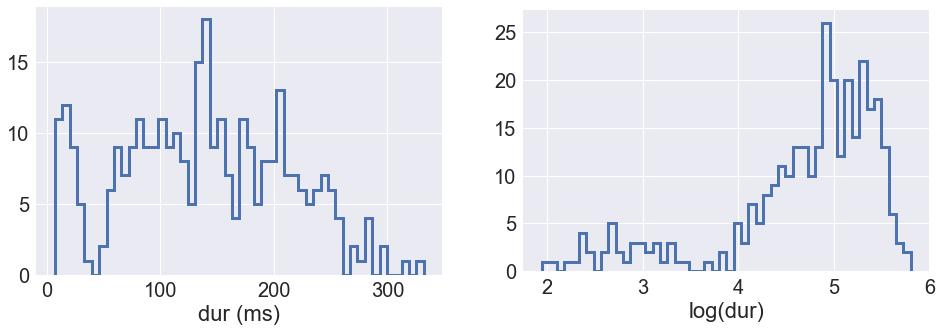

In [48]:
fig, axes = plt.subplots(1,2,figsize=(16,8))
ax1, ax2 = axes; ax1.set_aspect(12.5); ax2.set_aspect(1/10)
ax1.hist(cons['condur'],bins=50,histtype='step',lw=3); ax1.set(xlabel='dur (ms)')
ax2.hist(np.log(cons['condur']),bins=50,histtype='step',lw=3); ax2.set(xlabel='log(dur)');

And we can specify transformations in the formula using the `smf` module:

In [49]:
fit_f = smf.glm('voice ~ np.log(condur)*slab', data=cons, family=sm.families.Binomial()).fit()
print(fit_f.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  voice   No. Observations:                  320
Model:                            GLM   Df Residuals:                      316
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -171.59
Date:                Fri, 23 Mar 2018   Deviance:                       343.19
Time:                        12:17:45   Pearson chi2:                     294.
No. Iterations:                     5                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       20.7851      3.800      5.470      0.000      13.337      28.23

In order to use seaborn's `lmplot`, we need to create a new variable that is the log of vowdur:

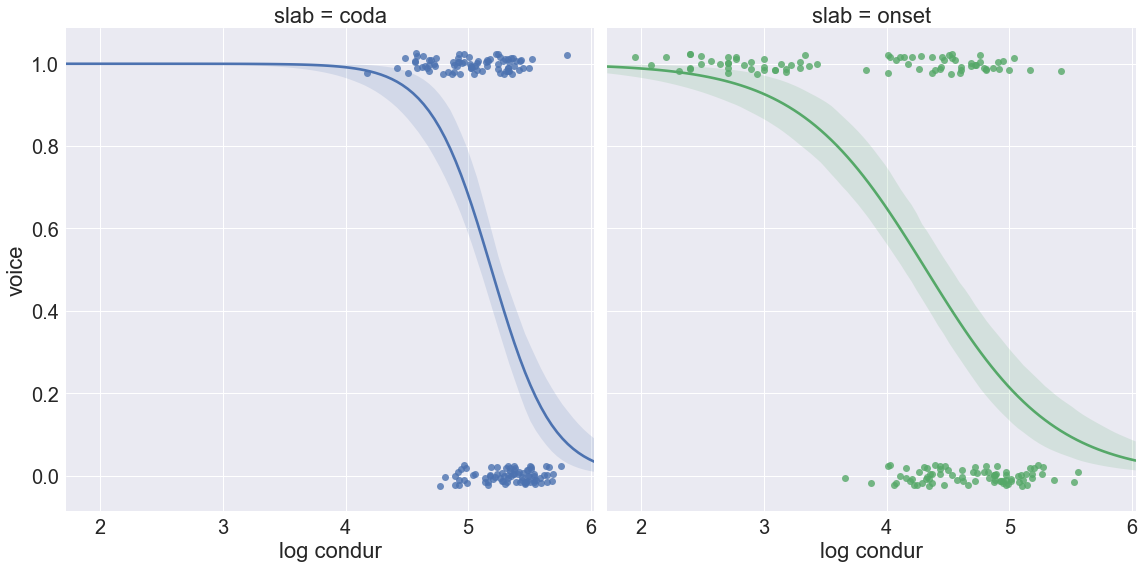

In [28]:
cons['log condur'] = np.log(cons['condur'])
sns.lmplot(x='log condur', y='voice', data=cons, hue='slab', col='slab', logistic=True, size=8, y_jitter=.025);

### Regularization

Statsmodels also has some more recently developed model fitting tools.

For example, you can fit regularized models. Regularization puts a penalty on the magnitude of the model coefficients. The end result of this is often that small coefficients are forced to be zero. It's similar in some ways to the pressure that the group-level model puts on the individual-level coefficients in a multilevel models, as discussed above. We will come back to this again later.

For now, here's an example:

In [56]:
y = cons['voice'].as_matrix() # predicting voice (1 = voiced, 0 = voiceless)
n_obs = len(y) # number of observations
x_np = cons['noipow'].as_matrix() # using noise power as a predictor
x_cd = np.log(cons['condur'].as_matrix()) # and consonant duration
x_sb = np.in1d(cons['slab'],'coda') # and syllable position
x = np.stack((np.ones(n_obs),x_np,x_cd,x_np*x_sb,x_cd*x_sb),axis=1) # predictor matrix (w/ column of ones)
mod_g = sm.Logit(endog=y, exog=x) # logistic regression model object
fit_g1 = mod_g.fit_regularized(alpha=5) # use method fit_regularized()
print(fit_g1.summary())

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.641124232065576
            Iterations: 13
            Function evaluations: 20
            Gradient evaluations: 13
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  320
Model:                          Logit   Df Residuals:                      317
Method:                           MLE   Df Model:                            2
Date:                Fri, 23 Mar 2018   Pseudo R-squ.:                  0.1015
Time:                        12:28:06   Log-Likelihood:                -199.28
converged:                       True   LL-Null:                       -221.81
                                        LLR p-value:                 1.652e-10
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------


/Users/noahsilbert/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/noahsilbert/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/noahsilbert/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [57]:
fit_g2 = mod_g.fit()
print(fit_g2.summary())

Optimization terminated successfully.
         Current function value: 0.544799
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  320
Model:                          Logit   Df Residuals:                      317
Method:                           MLE   Df Model:                            2
Date:                Fri, 23 Mar 2018   Pseudo R-squ.:                  0.2140
Time:                        12:30:54   Log-Likelihood:                -174.34
converged:                       True   LL-Null:                       -221.81
                                        LLR p-value:                 2.418e-21
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.7160      2.416      6.091      0.000       9.981      19.451
x1            -0.0394      0.

### Classification with logistic regression

Finally, we can use a logistic regression model as a classification model. Consider again the model predicting voicing as a function of vowel duration. We'll re-plot just the fitted values for the coda and onset data, along with three possible classification criteria (horizontal dotted lines):

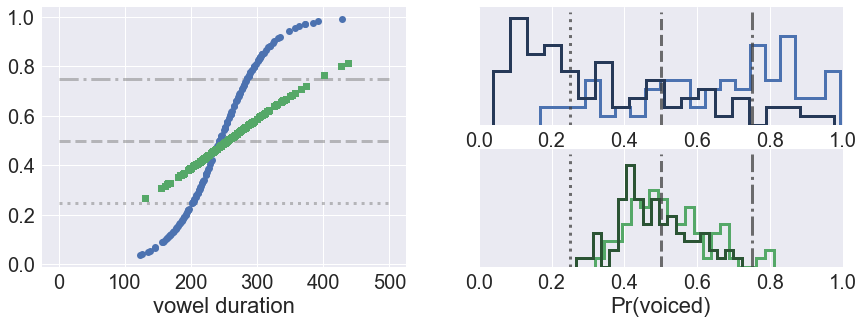

In [62]:
# coda rows, onset rows
c_rows = np.in1d(cons['slab'],'coda')
o_rows = np.in1d(cons['slab'],'onset')

# coda voiced rows, onset voiced rows
c_voice = np.in1d(cons.loc[c_rows,'vlab'],'voiced')
o_voice = np.in1d(cons.loc[o_rows,'vlab'],'voiced')

# fitted coda values, fitted onset values
c_fitted = fit_d.fittedvalues[c_rows]
o_fitted = fit_d.fittedvalues[o_rows]

# coda vowel duration, onset vowel duration
c_vowdur = cons.loc[c_rows,'vowdur']
o_vowdur = cons.loc[o_rows,'vowdur']

# set up grid of axes
fig = plt.figure(figsize=(30,10)); ax1 = plt.subplot2grid((4,4),(0,0),rowspan=2)
ax2 = plt.subplot2grid((4,4),(0,1)); ax3 = plt.subplot2grid((4,4),(1,1)); ax2.set_xlim(0,1); ax3.set_xlim(0,1)

# plot predicted/fitted values and classification criteria
ax1.hlines(y=[.25,.5,.75],xmin=0,xmax=500,colors=[.5,.5,.5,.5],linestyles=[':','--','-.'],lw=3)
ax1.plot(c_vowdur,c_fitted,'o',color=blue) # coda
ax1.plot(o_vowdur,o_fitted,'s',color=green) # onset
ax1.set_xlabel('vowel duration')

# histograms of coda vowel durations for voiced and voiceless consonants
ax2.hist(c_fitted[c_voice],histtype='step',bins=20,lw=3,color=blue) 
ax2.hist(c_fitted[~c_voice],histtype='step',bins=20,lw=3,color=np.array(blue)*.5); ax2.set_yticks([])
ax2.vlines([.25,.5,.75],ymin=0,ymax=ax2.get_ylim()[1],linestyles=[':','--','-.'],colors=[.25,.25,.25,.75],lw=3)

# histograms of onset vowel durations for voiced and voiceless consonants
ax3.hist(o_fitted[o_voice],histtype='step',bins=20,lw=3,color=green)
ax3.hist(o_fitted[~o_voice],histtype='step',bins=20,lw=3,color=np.array(green)*.5); ax3.set_yticks([])
ax3.vlines([.25,.5,.75],ymin=0,ymax=ax2.get_ylim()[1],linestyles=[':','--','-.'],colors=[.25,.25,.25,.75],lw=3);
ax3.set_xlabel('Pr(voiced)');

The relatively steep fitted value function for the coda consonants (blue) indicates that vowel duration will provide a lot of information about consonant voicing, whereas the more shallow function for the onset consonants indicates that vowel duration is less informative.

The histograms for the coda consonants (top-right panel) illustrate the relatively large separation of the voiced and voiceless vowel duration distributions, while the histograms for onset consonants (bottom-right panel) illustrate the near-complete overlap of vowel durations for voice and voiceless consonants.

The three vertical broken lines in each panel illustrate three possible classification criteria. The left most (dotted) line is a very liberal classification rule (relative to the category 'voiced'), according to which any consonant with a fitted value greater than 0.25 is classified as 'voiced'. The middle (dashed) line indicates a moderate rule such that any consonant with a fitted value greater than 0.5 is classified as 'voiced', and the right most (dash-dot) line uses the conservative criterion 0.75.

Here are confusion matrices for each of these criteria for the onset and coda data and models:

In [63]:
criteria = np.array([0.25, 0.5, 0.75])
onset_mats = np.zeros((3,2,2), dtype=int)
coda_mats = np.zeros((3,2,2), dtype=int)

for ci, cc in enumerate(criteria):
    onset_mats[ci,0,0] = np.sum(np.less_equal(o_fitted,cc) & ~o_voice)
    onset_mats[ci,0,1] = np.sum(np.greater_equal(o_fitted,cc) & ~o_voice)
    onset_mats[ci,1,0] = np.sum(np.less_equal(o_fitted,cc) & o_voice)
    onset_mats[ci,1,1] = np.sum(np.greater_equal(o_fitted,cc) & o_voice)

    coda_mats[ci,0,0] = np.sum(np.less_equal(c_fitted,cc) & ~c_voice)
    coda_mats[ci,0,1] = np.sum(np.greater_equal(c_fitted,cc) & ~c_voice)
    coda_mats[ci,1,0] = np.sum(np.less_equal(c_fitted,cc) & c_voice)
    coda_mats[ci,1,1] = np.sum(np.greater_equal(c_fitted,cc) & c_voice)

For each 2 x 2 matrix, the first (top) row is for voiceless consonants, and the second (bottom) row is for voiced consonants, and the first (left) column is for "voiceless" classifications (i.e., the model says "voiceless") and the second (right) column is for "voiced" classifications.

In [64]:
onset_mats

array([[[ 0, 80],
        [ 0, 80]],

       [[49, 31],
        [41, 39]],

       [[80,  0],
        [77,  3]]])

In [65]:
coda_mats

array([[[36, 44],
        [ 4, 76]],

       [[61, 19],
        [19, 61]],

       [[74,  6],
        [44, 36]]])

If we take a large number of criteria, ranging from the most conservative to the most liberal, and we calculate the probability of a hit (i.e., correctly classifying a voiced consonant as voiced) and the probability of a false alarm (i.e., incorrectly classifying a voiceless consonant as voiced), we get Receiver Operating Characteristic (ROC) curves, which give an indication of the overall classification accuracy of a given model (as well as some additional information):

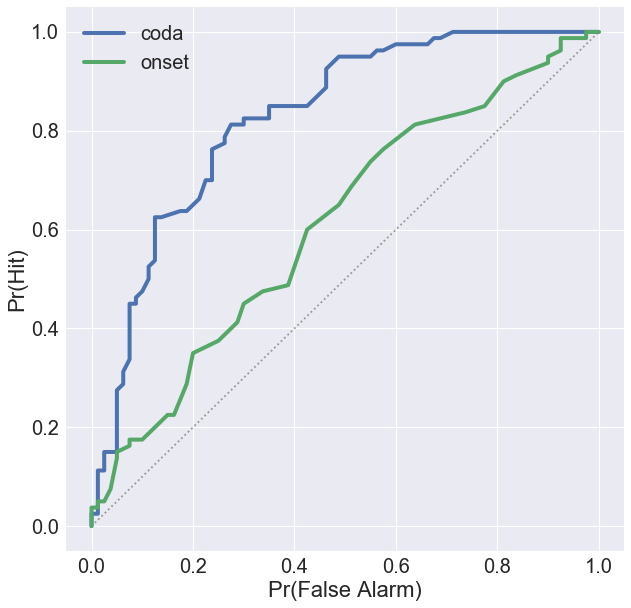

In [35]:
# number of voiced and voiceless consonant in each syllable position
n_cv = np.sum(c_voice); n_cl = np.sum(~c_voice)
n_ov = np.sum(o_voice); n_ol = np.sum(~o_voice)

# criteria, ROC vector initialization
criteria = np.linspace(1,0,101)
n_crit = len(criteria)
c_roc = np.zeros((n_crit,2)); o_roc = np.zeros((n_crit,2))

# calculate hit and FA probabilities
for i,crit in enumerate(criteria):
    c_hit = np.sum(np.greater_equal(c_fitted,crit) & c_voice)/n_cv
    c_fa = np.sum(np.greater_equal(c_fitted,crit) & ~c_voice)/n_cl
    c_roc[i,:] = c_fa,c_hit
    o_hit = np.sum(np.greater_equal(o_fitted,crit) & o_voice)/n_ov
    o_fa = np.sum(np.greater_equal(o_fitted,crit) & ~o_voice)/n_ol
    o_roc[i,:] = o_fa,o_hit
    
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.plot([0,1],[0,1],':',color=[.5,.5,.5,.5])
lc, = ax.plot(c_roc[:,0],c_roc[:,1],lw=4,color=blue)
ax.plot([0,1],[0,1],':',color=[.5,.5,.5,.5])
lo, = ax.plot(o_roc[:,0],o_roc[:,1],lw=4,color=green)
ax.set_ylabel('Pr(Hit)'); ax.set_xlabel('Pr(False Alarm)')
ax.legend([lc,lo],['coda','onset']);

## Summary

The `statsmodels` module contains a number of useful statistical model fitting tools. We looked at just a small sample of them here: ordinary least-squares linear regression, logistic regression, multilevel linear regression, generalized estimating equations, and regularized logistic regression. We also briefly discussed the use of logistic regression as a classification model.